# 피부암 분류

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torchvision.transforms as T

import timm

from sklearn.metrics import f1_score

import wandb

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

In [3]:
wandb.login(key='')
run = wandb.init(project='cv_79_part2_7', name='training')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: greedjar74 (greedjar7498). Use `wandb login --relogin` to force relogin


# CustomDataset

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, df, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms

        for i in range(df.shape[0]):
            img = df.iloc[i, 0]
            img_dir = os.path.join(root_path, img+'.jpg')
            classes = df.iloc[i, 1:]
            cls = classes.tolist().index(1)
            self.data.append((img_dir, cls))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        label = self.data[idx][1]

        return img, label

In [5]:
train_df = pd.read_csv('/Users/kimhongseok/cv_79_projects/part2/7/data/train.csv')
valid_df = pd.read_csv('/Users/kimhongseok/cv_79_projects/part2/7/data/val.csv')
test_df = pd.read_csv('/Users/kimhongseok/cv_79_projects/part2/7/data/test.csv')

transforms = T.Compose([
    T.Resize((112, 112)),
    T.ToTensor()
])

train_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/7/data/train', train_df, transforms)
valid_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/7/data/val', valid_df, transforms)
test_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/7/data/test', test_df, transforms)

In [6]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 100, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, 100, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 100, shuffle=False)

In [7]:
test_dataset[300][1]

3

# train, eval

In [8]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    total_labels = []
    total_preds = []
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, preds = torch.max(probs, 1)
        train_accuracy += (preds == labels).sum().item()

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataset)
    train_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, train_loss, train_accuracy, train_f1

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0
    total_labels = []
    total_preds = []

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, preds = torch.max(probs, 1)
            valid_accuracy += (preds==labels).sum().item()

            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_accuracy /= len(valid_dataset)
    valid_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, valid_loss, valid_accuracy, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)
    for epoch in range(num_epochs):
        model, train_loss, train_accuracy, train_f1 = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy, valid_f1 = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        monitoring = {'Train Loss': train_loss, 'Train Accuracy': train_accuracy, 'Train F1': train_f1,
                      'Valid Loss': valid_loss, 'Valid Accuracy': valid_accuracy, 'Valid F1': valid_f1}
        run.log(monitoring, step=epoch)

    return model

# model

In [9]:
model = timm.create_model(
    'resnet18',
    pretrained=True,
    num_classes=5
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [10]:
model.fc

Linear(in_features=512, out_features=5, bias=True)

In [11]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 5)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

# Test

In [13]:
model.eval()
total_labels = []
total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        
        max_prob, preds = torch.max(probs, 1)
        
        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

  0%|          | 0/13 [00:00<?, ?it/s]

In [14]:
f1_score(total_labels, total_preds, average='macro')

0.2562592980379249

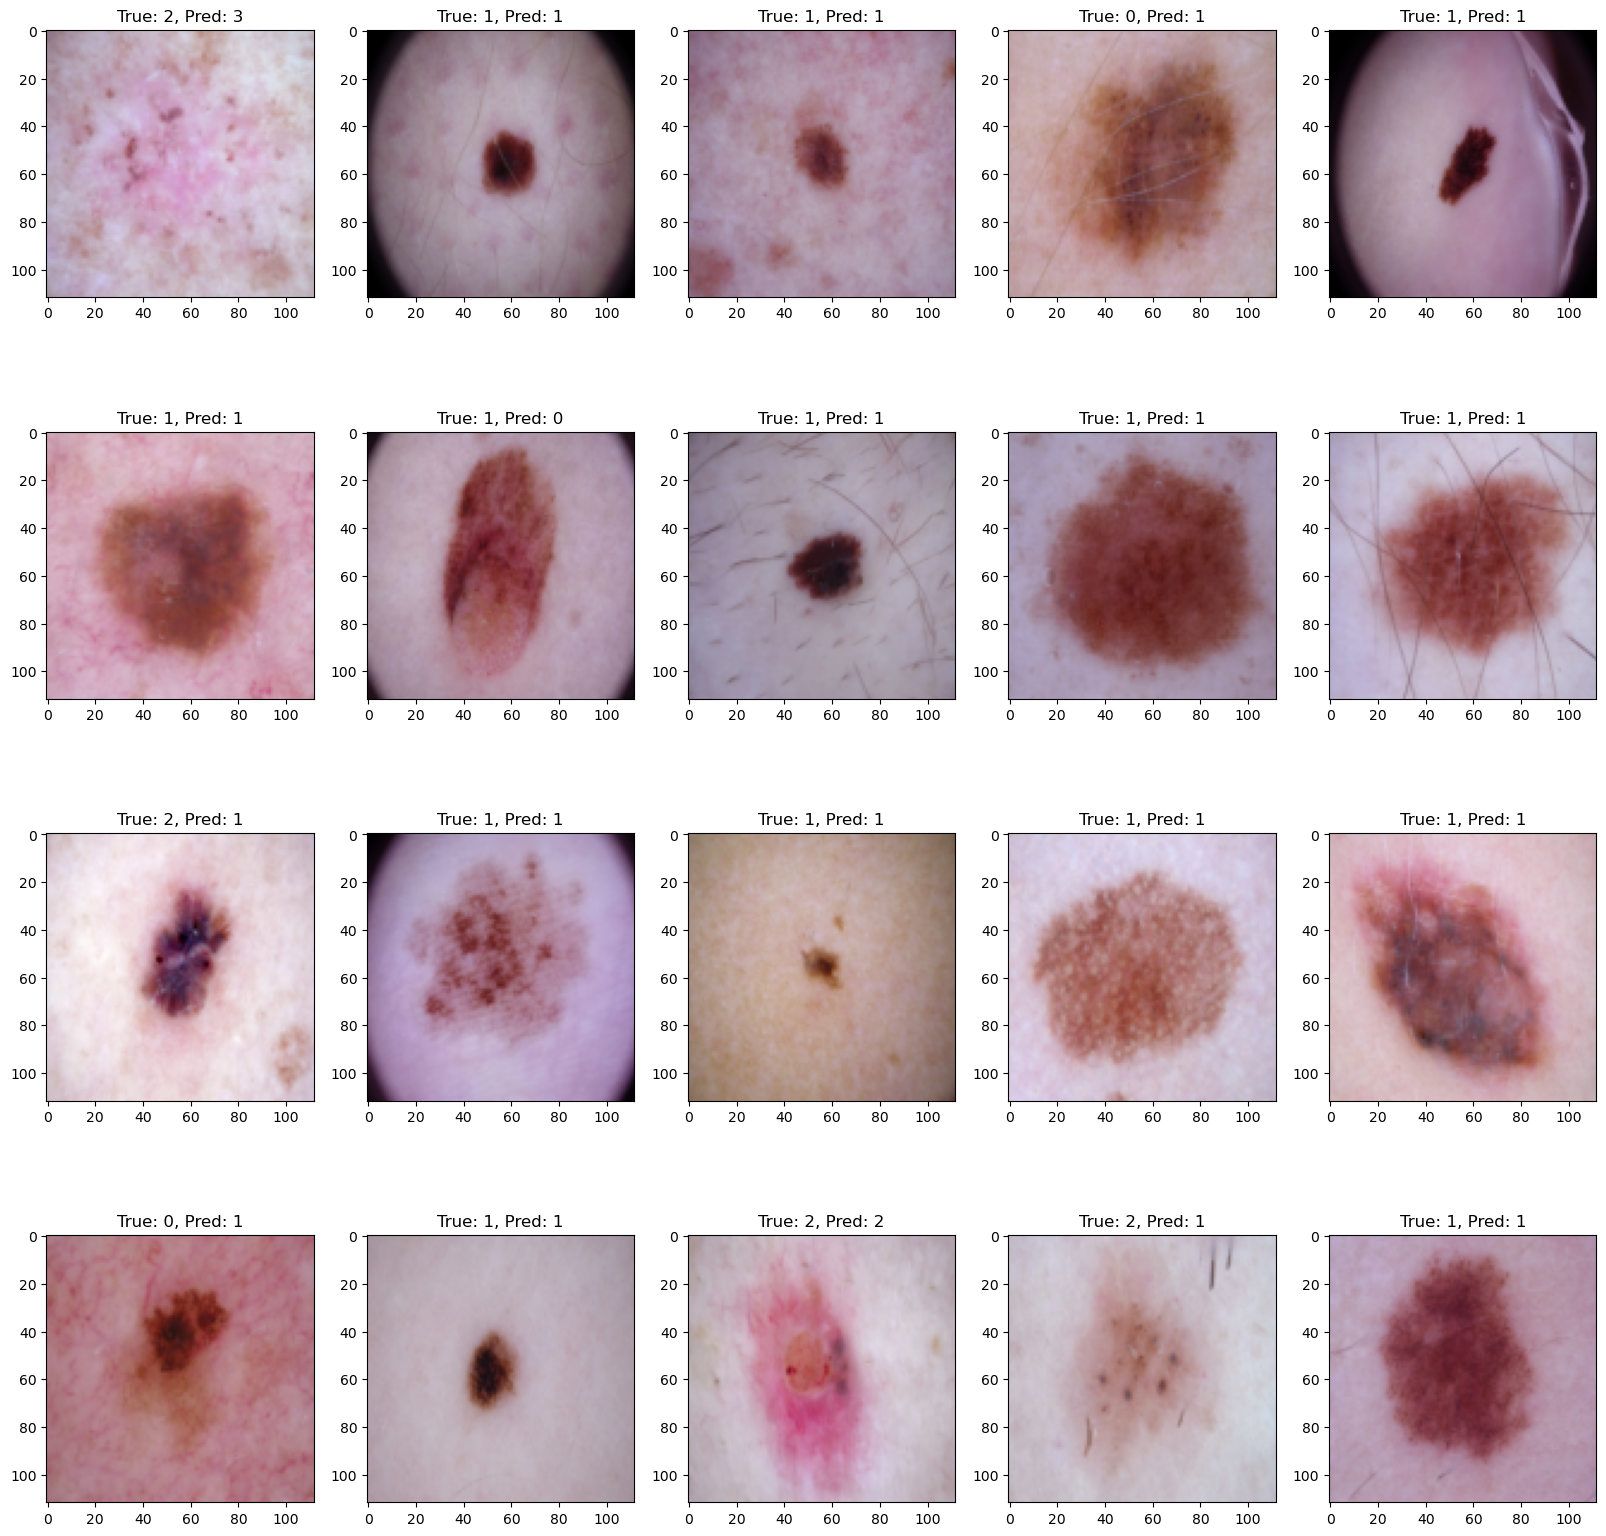

In [16]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(f'True: {test_dataset[i][1]}, Pred: {total_preds[i]}')